# Dip Adjusted Samples

This notebook will enable plotting of dip adjusted samples

## Import packages

In [1]:
# general
import numpy as np
from tqdm import tqdm
import pandas as pd

# plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib


# My packages
# my functions/classes
import sys
sys.path.append("../core_scripts/")
from ECMclass import ECM, core_section


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Set up

In [2]:
# Set filepaths

path_to_data = '../../data/'
path_to_samples = '../../data/sampling/master/'
path_to_angles = '../../data/angles/'
path_to_figures = '../../../figures/dip_adjusted_samples/'

## Load Data

In [3]:
# load unit data
units = pd.read_excel(path_to_data+'sampling/units.xlsx')

In [4]:
# Load dip data
angles = pd.read_csv(path_to_angles + 'angles.csv')
angles.head()

,core,section,ACorDC,top_angle,left_angle,right_angle,side_angle,true_dip,true_dip_angles,true_dip_scores
0,alhic1901,228_4,AC,-36.776051,16.199769,-10.606322,13.403045,-38.643013,[-38.87808981 -38.54424142 -39.18075393 -37.73...,[0.88933205 0.97882252 0.95474921 0.95895482 0...
1,alhic1901,230_4,AC,27.819776,30.749623,-30.156336,30.452979,38.799076,[36.94242001 34.92239342 34.74296877 37.507310...,[0.99150915 0.99005042 0.99079277 0.99085791 0...


In [5]:
# Load ECM data

# Load metadata
meta = pd.read_csv(path_to_data + 'ecm/raw/metadata.csv')
meta.head()

# set smoothing window
window = 10

# Load ECM data
data = []
cores = []
sections = []
faces = []
ACorDCs = []
for index, row in tqdm(meta.iterrows(), total=len(meta), desc="Processing data"):
    
    core = row['core']
        
    section = row['section']
    face = row['face']
    ACorDC = row['ACorDC']

    if ACorDC == 'AC' and not face == 'o':

        data_item = ECM(core,section,face,ACorDC,path_to_data + 'ecm/raw/')
        print("Reading "+core+", section "+section+'-'+face+'-'+ACorDC)
        
        data_item.rem_ends(15)
        data_item.smooth(window)
        data.append(data_item)
        
        cores.append(core)
        sections.append(section)
        faces.append(face)
        ACorDCs.append(ACorDC)

# Put ECM data into core_section structure
s228_4_AC = core_section('228_4','alhic1901','AC',data,sections,faces,cores,ACorDCs)
s230_4_AC = core_section('230_4','alhic1901','AC',data,sections,faces,cores,ACorDCs)

# place in 3D space
for s in [s228_4_AC,s230_4_AC]:
    s.add_3d_coords()

# add angles
for s in [s228_4_AC,s230_4_AC]:
    s.get_angles(angles)


Processing data:   0%|          | 0/13 [00:00<?, ?it/s]

Reading alhic1901, section 228_4-l-AC


Processing data:  31%|███       | 4/13 [00:00<00:00, 18.25it/s]

Reading alhic1901, section 230_4-l-AC


Processing data:  46%|████▌     | 6/13 [00:00<00:00, 12.25it/s]

Reading alhic1901, section 230_4-t-AC


Processing data:  69%|██████▉   | 9/13 [00:01<00:00,  4.55it/s]

Reading alhic1901, section 230_4-r-AC
Reading alhic1901, section 228_4-r-AC


Processing data:  85%|████████▍ | 11/13 [00:01<00:00,  5.66it/s]

Reading alhic1901, section 228_4-t-AC


Processing data: 100%|██████████| 13/13 [00:02<00:00,  5.68it/s]


In [6]:
# load sample data
samps = ['water_iso','cc','ic_icpms','cfa','ghg','ecm_median']

# loop through and load all sample files
for s in samps:

    if s == samps[0]:
        samp_data = pd.read_csv(path_to_samples + s+'_master.csv')

    else:

        df = pd.read_csv(path_to_samples + s+'_master.csv')
        samp_data = pd.concat([samp_data, df], ignore_index=True)


    

## Make some functions

In [ ]:
def plot_ecm(axs,face,top_angle,cmap):

    res = 0.002

    meas = face.meas_s
    button = face.button_s
    ycor = face.y_s
    d = face.depth_s
    x_vector = face.x_3d
    y_vector = face.y_3d
    tracks = np.unique(x_vector)

    # define rescale
    pltmin = np.percentile(meas,5)
    pltmax = np.percentile(meas,95)
    rescale = lambda k: (k-pltmin) /  (pltmax-pltmin)

    # define width of track
    width = tracks[2] - tracks[1]

    for x in tracks:
        
        # Pull out data for this track
        idx = x_vector==x
        tmeas = meas[idx]
        tbut = button[idx]
        td = d[idx]

        # calculate the shift
        depth_shift = x * np.tan(top_angle * np.pi/180)
        td = td + depth_shift

        # downsample ECM to save plotting time (as needed)
        if res != 0:
            int_lo = round(min(td),2)
            int_hi = round(max(td),2)
            depth_interp = np.linspace(int_lo,int_hi,int((int_hi-int_lo)/res)+1)
            meas_interp = np.interp(depth_interp,np.flip(td),np.flip(tmeas))
            but_interp = np.interp(depth_interp,np.flip(td),np.flip(tbut))
            td = depth_interp
            tmeas = meas_interp
            tbut = np.round(but_interp)
        
        for i in range(len(tmeas)-1):
            
            if tbut[i] == 0:
                axs.add_patch(Rectangle((x-(width-0.001)/2,td[i]),(width-0.001),td[i+1]-td[i],facecolor=cmap(rescale(tmeas[i]))))
            else:
                axs.add_patch(Rectangle((x-(width-0.001)/2,td[i]),(width-0.001),td[i+1]-td[i],facecolor=cmap(rescale(tmeas[i]))))

    return pltmin, pltmax

In [13]:
# plot sample
def plot_sample(ax0,axs,samp_data,top_angle,side_angle,cmap,c_cnt,p):

    # filter samp_data for only rows where the column p is not empty
    samp_data = samp_data[samp_data[p].notna()]

    #get unique values in column 'sticks'
    sticks = samp_data['stick'].unique()

    # loop through each unique value in column 'sticks'
    for s in sticks:

        # filter samp_data for only rows where the column 'sticks' is equal to s
        df = samp_data[samp_data['stick'] == s]

        # compute the shift
        shift = df['effective_center_x'] * np.tan(top_angle * np.pi/180) + df['effective_center_y'] * np.tan(side_angle * np.pi/180)
        df['mid_depth_shifted'] = df['mid_depth'] + shift
        df['top_depth_shifted'] = df['top_depth'] + shift
        df['bottom_depth_shifted'] = df['bottom_depth'] + shift

        # compute shifts for four corners of the cube
        left_shift = df['x_lo'] * np.tan(top_angle * np.pi/180) + df['effective_center_y'] * np.tan(side_angle * np.pi/180)
        right_shift =  df['x_hi'] * np.tan(top_angle * np.pi/180) + df['effective_center_y'] * np.tan(side_angle * np.pi/180)
        #print("left_shift",left_shift[0])
        #print("right_shift",right_shift[0])
        df['top_depth_left'] = df['top_depth'] + left_shift
        df['top_depth_right'] = df['top_depth'] + right_shift
        df['bottom_depth_left'] = df['bottom_depth'] + left_shift
        df['bottom_depth_right'] = df['bottom_depth'] + right_shift

        # get the color
        color = cmap(c_cnt)

        # plot the line
        axs.plot(df[p],df['mid_depth_shifted'],color=color,linewidth=2)


        for index,row in df.iterrows():

            # plot the cube
            ax0.plot([row['x_lo'],row['x_hi']],[row['top_depth_left'],row['top_depth_right']],color=color)
            ax0.plot([row['x_lo'],row['x_hi']],[row['bottom_depth_left'],row['bottom_depth_right']],color=color)
            ax0.plot([row['x_lo'],row['x_lo']],[row['bottom_depth_left'],row['top_depth_left']],color=color)
            ax0.plot([row['x_hi'],row['x_hi']],[row['bottom_depth_right'],row['top_depth_right']],color=color)
            # ax0.plot([row['x_lo'],row['x_hi'],row['x_hi'],row['x_lo'],row['x_lo']],
            #          [row['top_depth_right'],row['top_depth_right'],row['bottom_depth_left'],row['bottom_depth_left'],row['top_depth_right']],
            #          color=color)

            # plot the line
            axs.plot([row[p],row[p]],[row['top_depth_shifted'],row['bottom_depth_shifted']],color=color,linewidth=2)

        # plot the cube



        c_cnt+=1

    return(c_cnt)



In [14]:

def make_full_plot(sec,proxies,side_angle,top_angle):

    # set colormap - ecm
    my_cmap = matplotlib.colormaps['Spectral']

    # set colormap - lines
    cmap_line = matplotlib.colormaps['tab10']

    # filter samp_data for only rows where 'section' is equal to sec.section
    samp_data_sec = samp_data[samp_data['section'] == sec.section]

    # add side angle
    if side_angle is None:
        side_angle = sec.side_angle
    if top_angle is None:
        top_angle = sec.top_angle

    # set top and bottom depths
    td = min(sec.top.depth_s) - 0.12
    bd = max(sec.top.depth_s) + 0.12

    # Make figure (sized for number of proxies to plot)
    ratios = [3]
    numplots=2
    if len(proxies)>0:
        numplots=1+len(proxies)
    for i in range(len(proxies)):
        ratios.append(2)
    fig, ax = plt.subplots(1, numplots,figsize=(8+len(proxies)*3,9),gridspec_kw={'width_ratios': ratios},dpi=100)

    # ecm subplot admin
    ax[0].set_xlim([-.120,.120])
    ax[0].set_xlabel('Distance accross core (m)')
    ax[0].set_ylabel('Depth (m)')
    ax[len(proxies)].yaxis.set_label_position('right')
    ax[len(proxies)].yaxis.tick_right()
    ax[len(proxies)].set_ylabel('Depth (m)')
    ax[0].set_title('ECM and Sample Locations')

    for axs in ax:
        axs.set_ylim([bd,td])

    # plot ECM data
    pltmin, pltmax = plot_ecm(ax[0],sec.top,top_angle,my_cmap)

    # loop through proxies
    c_cnt=0
    for i in range(len(proxies)):

        # pull out values
        p = proxies[i]
        axs = ax[i+1]

        # plot the proxy data (c_cnt keeps tracks of which colors have been used)
        c_cnt = plot_sample(ax[0],axs,samp_data_sec,top_angle,side_angle,cmap_line,c_cnt,p)

        # axis housekeeping
        if i==range(len(proxies)): # if last one
            axs.yaxis.set_label_position('right')
        else:
            axs.set_yticklabels([]) 

        # look up fancy name and units
        unit_row = units.loc[units['simple_name'] == p]
        if len(unit_row) == 1:
            full_name = unit_row.latex_name.iloc[0]
            unit = unit_row.units.iloc[0]
        else:
            full_name = p
            unit = ''
        axs.set_xlabel('$'+full_name + '\:(' + unit + ')$')
        axs.set_title('$' + full_name + '$')

    for a in ax:
        a.grid(axis='y')
    fig.tight_layout()
    plt.subplots_adjust(wspace=0)

    # add colorbar (width fixed to first two subplots)
    cbar_ax = fig.add_axes([ax[0].get_position().x0,-0.05,ax[0].get_position().x1-ax[0].get_position().x0,0.05])
    norm = matplotlib.colors.Normalize(vmin=pltmin,vmax=pltmax)
    cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=my_cmap),cax=cbar_ax,
                    orientation='horizontal',label='AC Current (amps)')


In [15]:
# define function inputs (temporary)
sec = s228_4_AC
proxies = ['d18O','co2']
side_angle = None
top_angle = None



## Now let's make some plots!!!

Width of track: 0.009999999999999995


/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_80421/1170454103.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mid_depth_shifted'] = df['mid_depth'] + shift
/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_80421/1170454103.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['top_depth_shifted'] = df['top_depth'] + shift
/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_80421/1170454103.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Width of track: 0.0049999999999999906


/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_80421/1170454103.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mid_depth_shifted'] = df['mid_depth'] + shift
/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_80421/1170454103.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['top_depth_shifted'] = df['top_depth'] + shift
/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_80421/1170454103.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

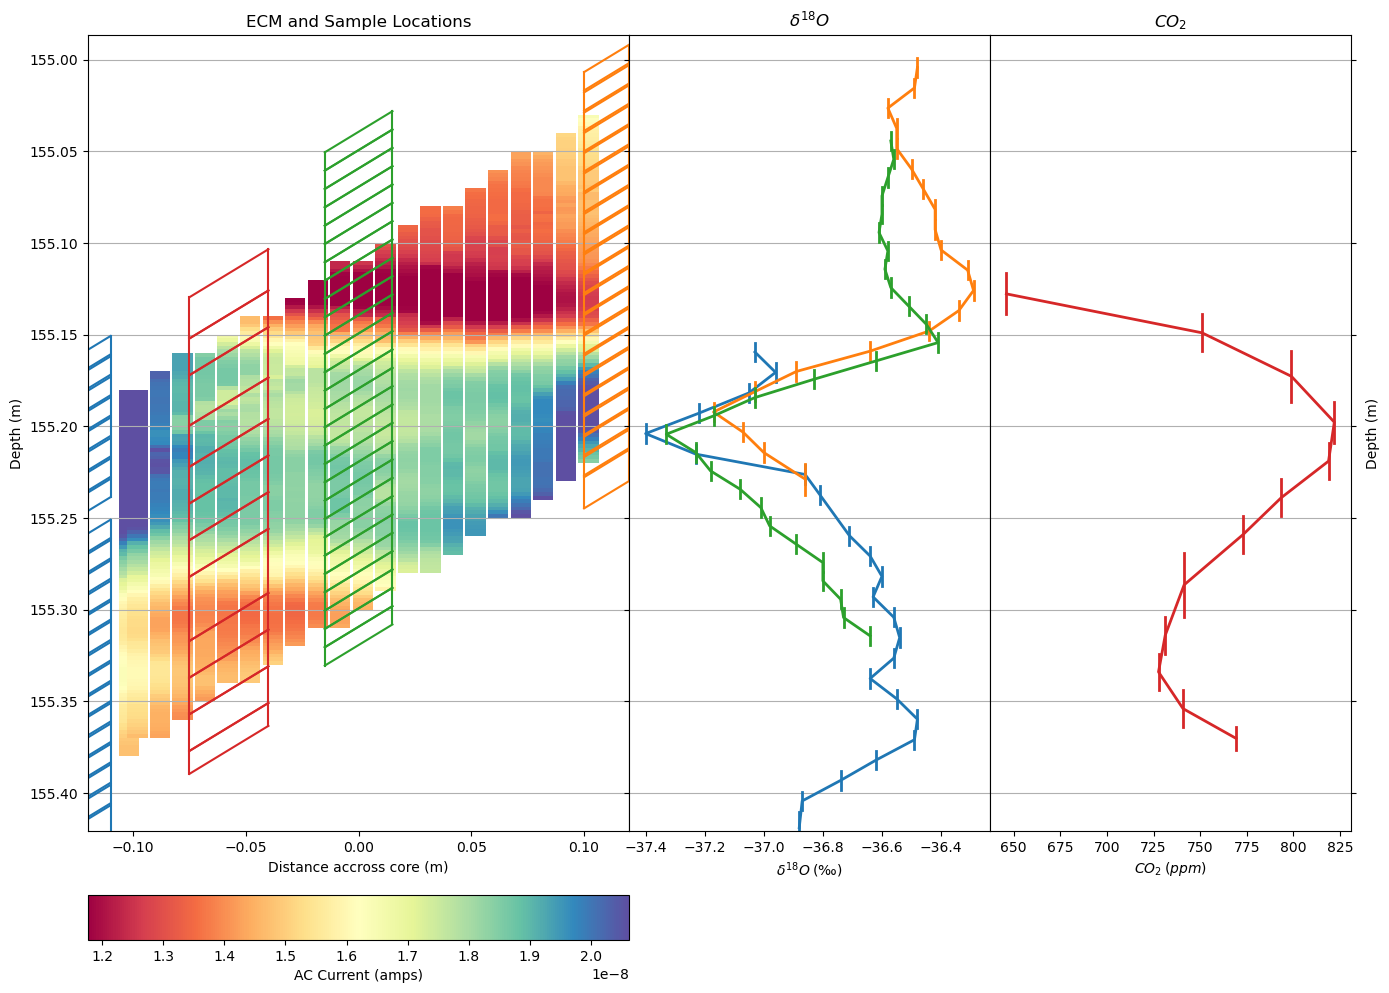

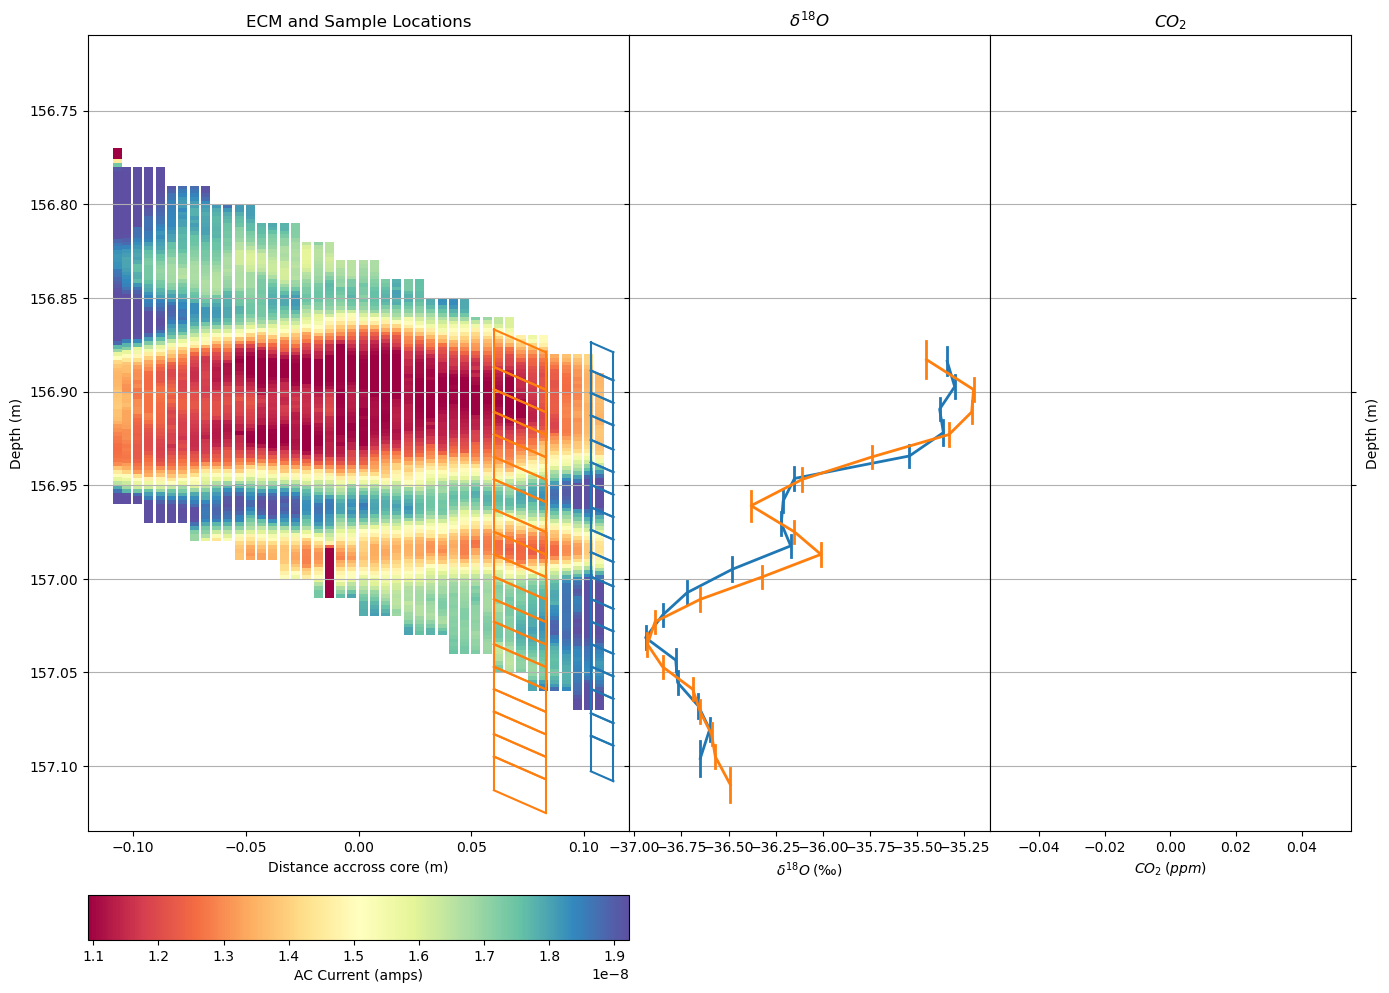

In [ ]:
make_full_plot(s228_4_AC,['d18O','co2'],s228_4_AC.side_angle,s228_4_AC.top_angle)


Width of track: 0.0049999999999999906


/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_80421/1170454103.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mid_depth_shifted'] = df['mid_depth'] + shift
/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_80421/1170454103.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['top_depth_shifted'] = df['top_depth'] + shift
/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_80421/1170454103.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

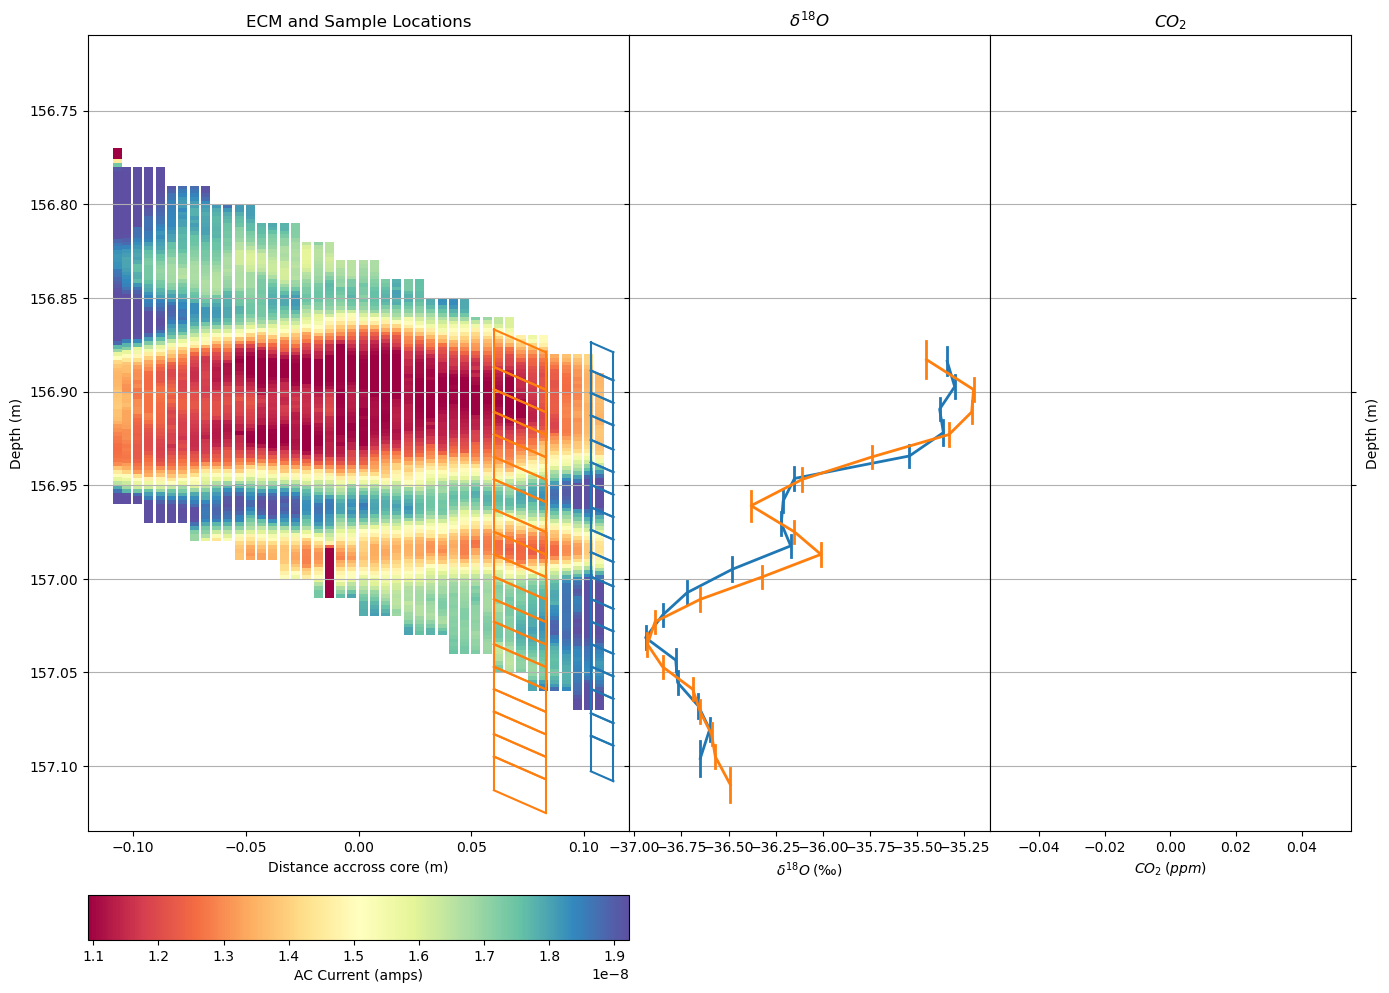

In [22]:
make_full_plot(s230_4_AC,['d18O','co2'],s230_4_AC.side_angle,s230_4_AC.top_angle)

In [21]:
samp_data_sec = samp_data[samp_data['section'] == '230_4']
samp_data_co2 = samp_data_sec[samp_data_sec['co2'].notna()]

samp_data_co2.head()

,section,stick,top_depth,bottom_depth,mid_depth,dD,d17O,d18O,dxs,x_lo,...,co2,ch4,tac,AC_ecm,xlo,xhi,ylo,yhi,core,DC_ecm
1608,230_4,co2,156.789,156.814,156.8015,NaN,NaN,NaN,NaN,NaN,...,929.653261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1609,230_4,co2,156.815,156.839,156.8270,NaN,NaN,NaN,NaN,NaN,...,930.446944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1610,230_4,co2,156.839,156.863,156.8510,NaN,NaN,NaN,NaN,NaN,...,914.586060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1611,230_4,co2,156.865,156.885,156.8750,NaN,NaN,NaN,NaN,NaN,...,905.495769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1612,230_4,co2,156.899,156.914,156.9065,NaN,NaN,NaN,NaN,NaN,...,913.692385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
